In [ ]:
## Môi trường lập trình
from google.colab import drive
drive.mount("/content/gdrive")
folder = '/content/gdrive'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install comet_ml

In [ ]:
pip install scikit-optimize

In [ ]:
import joblib                as jlb
import matplotlib.pyplot     as plt
import numpy                 as np
import pandas                as pd
import seaborn               as sbn

from comet_ml                import ConfusionMatrix
from sklearn                 import metrics
from sklearn.metrics         import accuracy_score, confusion_matrix
from sklearn.metrics         import auc,roc_curve
from sklearn.metrics         import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn                 import tree
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from collections             import OrderedDict
from skopt                   import BayesSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv(folder + '/MyDrive/Colab Notebooks/booking.csv')

In [ ]:
data.drop(["Booking_ID"], axis=1, inplace=True)
data.index = data.index + 1
print(data.shape)
data.head()

(36285, 16)


,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
1,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
2,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
3,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
4,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
5,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [ ]:
print('DataFrame shape:', data.shape)
print('DataFrame size:', data.size)

DataFrame shape: (36285, 16)
DataFrame size: 580560


CHECK NULL


In [ ]:
_column_totals = data.notnull().sum()
values_missing = _column_totals.loc[_column_totals < data.shape[0]]
print(values_missing)

Series([], dtype: int64)


LỌC NHIỄU

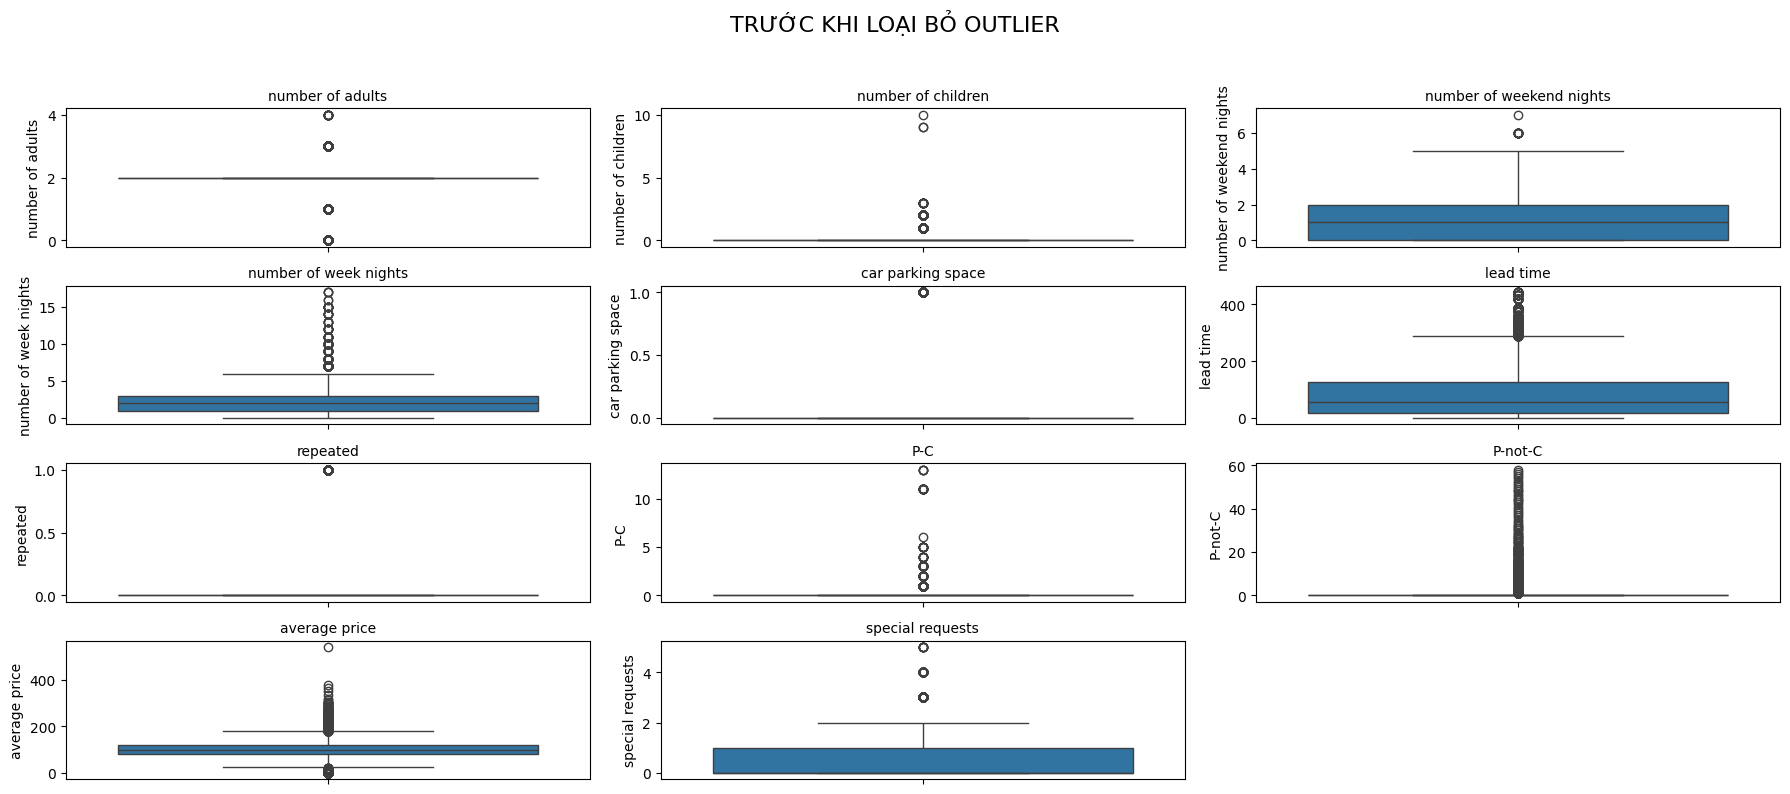

In [ ]:
# Lấy các cột số trong dataset
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(18, 12))
plt.suptitle('TRƯỚC KHI LOẠI BỎ OUTLIER', fontsize=16, y=0.95)

# Vẽ từng boxplot
for i, var in enumerate(numeric_columns):
    plt.subplot(6, 3, i + 1)
    sbn.boxplot(y=data[var])
    plt.title(f'{var}', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.93])  # Chừa không gian cho tiêu đề chung (0.93 là khoảng cách với phần trên)
plt.show()


In [ ]:
outliers_cols = ["lead time", "average price"]
for column in outliers_cols:
    if data[column].dtype in ["int64", "float64"]:
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data = data[
            (data[column] >= lower_bound) & (data[column] <= upper_bound)
        ]


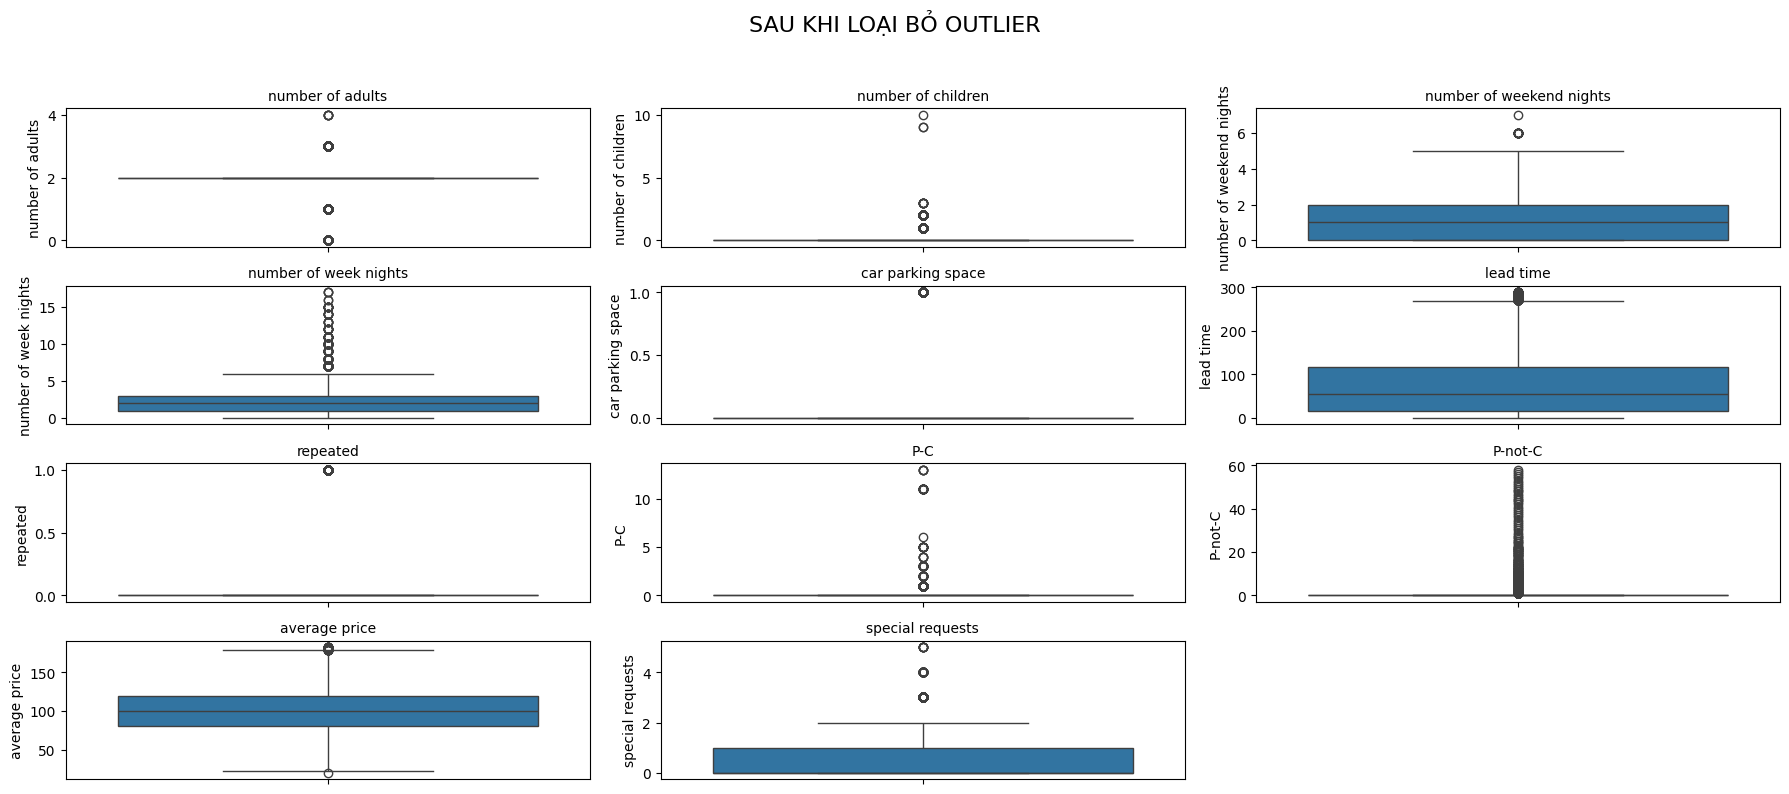

In [ ]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(18, 12))
plt.suptitle('SAU KHI LOẠI BỎ OUTLIER', fontsize=16, y=0.95)

# Vẽ từng boxplot
for i, var in enumerate(numeric_columns):
    plt.subplot(6, 3, i + 1)
    sbn.boxplot(y=data[var])
    plt.title(f'{var}', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


Chuẩn Hóa dữ liệu


In [ ]:
data = data[~data["date of reservation"].str.contains("-")]
data["date of reservation"] = pd.to_datetime(data["date of reservation"])

data["day"] = data["date of reservation"].dt.day
data["month"] = data["date of reservation"].dt.month
data["year"] = data["date of reservation"].dt.year

# Drop the original datetime column
data = data.drop(columns=["date of reservation"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33312 entries, 1 to 36285
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number of adults          33312 non-null  int64  
 1   number of children        33312 non-null  int64  
 2   number of weekend nights  33312 non-null  int64  
 3   number of week nights     33312 non-null  int64  
 4   type of meal              33312 non-null  object 
 5   car parking space         33312 non-null  int64  
 6   room type                 33312 non-null  object 
 7   lead time                 33312 non-null  int64  
 8   market segment type       33312 non-null  object 
 9   repeated                  33312 non-null  int64  
 10  P-C                       33312 non-null  int64  
 11  P-not-C                   33312 non-null  int64  
 12  average price             33312 non-null  float64
 13  special requests          33312 non-null  int64  
 14  booking sta

In [ ]:
data["booking status"] = data["booking status"].replace("Canceled", 1)
data["booking status"] = data["booking status"].replace("Not_Canceled", 0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33312 entries, 1 to 36285
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number of adults          33312 non-null  int64  
 1   number of children        33312 non-null  int64  
 2   number of weekend nights  33312 non-null  int64  
 3   number of week nights     33312 non-null  int64  
 4   type of meal              33312 non-null  object 
 5   car parking space         33312 non-null  int64  
 6   room type                 33312 non-null  object 
 7   lead time                 33312 non-null  int64  
 8   market segment type       33312 non-null  object 
 9   repeated                  33312 non-null  int64  
 10  P-C                       33312 non-null  int64  
 11  P-not-C                   33312 non-null  int64  
 12  average price             33312 non-null  float64
 13  special requests          33312 non-null  int64  
 14  booking sta

In [ ]:
object_columns = data.select_dtypes(include=["object"]).columns
data = pd.get_dummies(data, columns=object_columns)
data = data.replace({True: 1, False: 0})
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33312 entries, 1 to 36285
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   number of adults                   33312 non-null  int64  
 1   number of children                 33312 non-null  int64  
 2   number of weekend nights           33312 non-null  int64  
 3   number of week nights              33312 non-null  int64  
 4   car parking space                  33312 non-null  int64  
 5   lead time                          33312 non-null  int64  
 6   repeated                           33312 non-null  int64  
 7   P-C                                33312 non-null  int64  
 8   P-not-C                            33312 non-null  int64  
 9   average price                      33312 non-null  float64
 10  special requests                   33312 non-null  int64  
 11  booking status                     33312 non-null  int64  


In [ ]:
X = data.drop(["booking status"], axis=1)
y = data['booking status']
f_df = pd.concat([X, y], axis = 1)
print(f_df.head())

   number of adults  number of children  number of weekend nights  \
1                 1                   1                         2   
2                 1                   0                         1   
3                 2                   1                         1   
4                 1                   0                         0   
5                 1                   0                         1   

   number of week nights  car parking space  lead time  repeated  P-C  \
1                      5                  0        224         0    0   
2                      3                  0          5         0    0   
3                      3                  0          1         0    0   
4                      2                  0        211         0    0   
5                      2                  0         48         0    0   

   P-not-C  average price  ...  room type_Room_Type 4  room type_Room_Type 5  \
1        0          88.00  ...                      0             

Ma trận tương quan giữa các features

In [ ]:
mx = f_df.corr(method='spearman')

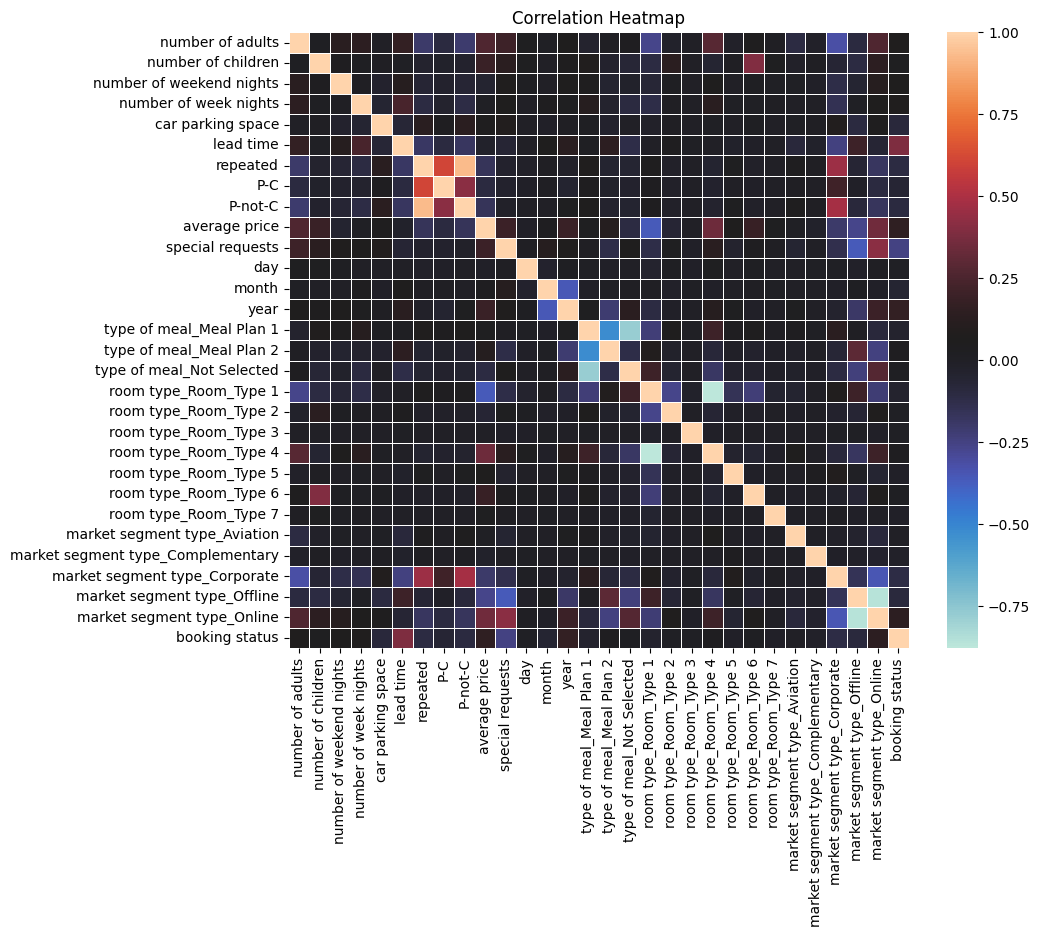

In [ ]:
plt.figure(figsize=(10, 8))
sbn.heatmap(mx, cmap="icefire", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
correlation_pairs = []
for i in range(len(mx.columns)):
    for j in range(i + 1, len(mx.columns)):
        col1 = mx.columns[i]
        col2 = mx.columns[j]
        correlation_value = mx.iloc[i, j]
        if abs(correlation_value) > 0.7:
            correlation_pairs.append((col1, col2, correlation_value))

# Hiển thị các cặp cột có tương quan lớn hơn 0.7
for col1, col2, value in correlation_pairs:
    print(f"Cặp features: {col1} và {col2}, Hệ số tương quan: {value:.2f}")

Cặp features: repeated và P-not-C, Hệ số tương quan: 0.93
Cặp features: type of meal_Meal Plan 1 và type of meal_Not Selected, Hệ số tương quan: -0.78
Cặp features: room type_Room_Type 1 và room type_Room_Type 4, Hệ số tương quan: -0.88
Cặp features: market segment type_Offline và market segment type_Online, Hệ số tương quan: -0.86


In [ ]:
k_best = SelectKBest(score_func=f_classif, k=10) #dùng F-test đánh giá mức độ tương quan của mỗi feature với target

X_ = k_best.fit_transform(X, y)
y_ = y

#Trả về danh sách chỉ số của các đặc trưng được chọn
selected_features_indices = k_best.get_support(indices=True)

#Trả về một mảng chứa giá trị F của tất cả các đặc trưng
feature_scores = k_best.scores_

#Tạo danh sách các tuples gồm các đặc trưng và score tương ứng
feature_info = list(zip(X.columns, feature_scores))

#Sắp xếp danh sách feature_info theo giá trị F giảm dần.
sorted_feature_info = sorted(feature_info, key=lambda x: x[1], reverse=True)
# in ra top 10 đặc trưng có giá trị F cao nhất
for feature_name, feature_score in sorted_feature_info[:10]:
    print(f"{feature_name}: {feature_score:.2f}")

lead time: 6755.25
special requests: 2136.14
year: 952.07
market segment type_Online: 646.78
average price: 617.23
market segment type_Corporate: 414.32
repeated: 343.90
market segment type_Offline: 250.21
number of week nights: 248.88
car parking space: 216.60


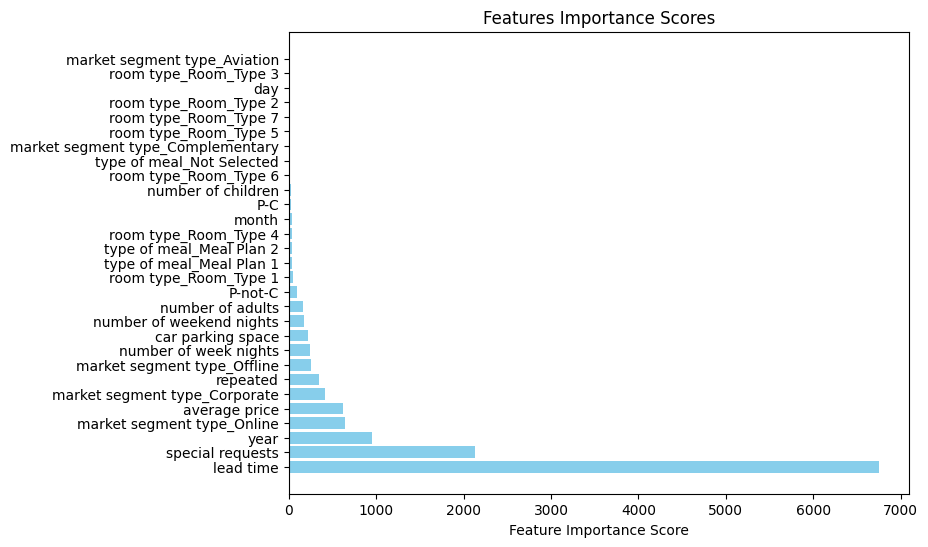

In [ ]:
feature_names, feature_scores = zip(*sorted_feature_info[:])

plt.figure(figsize=(8, 6))
plt.barh(feature_names, feature_scores, color="skyblue")
plt.xlabel("Feature Importance Score")
plt.title("Features Importance Scores")
plt.show()

In [ ]:
selected_features_df = X.iloc[:, selected_features_indices]
selected_features_df = selected_features_df.drop(['market segment type_Online'], axis=1) #do 2 features market segment type_Offline và market segment type_Online cso sự tương quan cao
selected_features_df.head(10)

,number of week nights,car parking space,lead time,repeated,average price,special requests,year,market segment type_Corporate,market segment type_Offline
1,5,0,224,0,88.00,0,2015,0,1
2,3,0,5,0,106.68,1,2018,0,0
3,3,0,1,0,50.00,0,2018,0,0
4,2,0,211,0,100.00,1,2017,0,0
5,2,0,48,0,77.00,0,2018,0,0
7,4,0,34,0,107.55,1,2017,0,0
8,3,0,83,0,105.61,1,2018,0,0
9,4,0,121,0,96.90,1,2018,0,1
10,5,0,44,0,133.44,3,2018,0,0
11,0,0,0,0,85.03,0,2018,0,0


In [ ]:
print(pd.concat([selected_features_df, y], axis = 1))

       number of week nights  car parking space  lead time  repeated  \
1                          5                  0        224         0   
2                          3                  0          5         0   
3                          3                  0          1         0   
4                          2                  0        211         0   
5                          2                  0         48         0   
...                      ...                ...        ...       ...   
36280                      1                  0         48         0   
36282                      3                  0         34         0   
36283                      3                  0         83         0   
36284                      4                  0        121         0   
36285                      5                  0         44         0   

       average price  special requests  year  market segment type_Corporate  \
1              88.00                 0  2015            

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(selected_features_df, y, test_size=0.2, random_state=1)

In [ ]:
ensemble_clfs = [
    (
        "RandomForestClassifier, max_features= 2",
        RandomForestClassifier(
            oob_score=True,
            max_features=2,
            random_state=42,
        ),
    ),
    (
        "RandomForestClassifier, max_features= 3",
        RandomForestClassifier(
            max_features=3,
            oob_score=True,
            random_state=42,
        ),
    ),
    (
        "RandomForestClassifier, max_features= 4",
        RandomForestClassifier(
            max_features=4,
            oob_score=True,
            random_state=42,
        ),
    ),
    (
        "RandomForestClassifier, max_features= 5",
        RandomForestClassifier(
            max_features=5,
            oob_score=True,
            random_state=42,
        ),
    ),
    (
        "RandomForestClassifier, max_features=6",
        RandomForestClassifier(
            max_features=6,
            oob_score=True,
            random_state=42,
        ),
    ),
    (
        "RandomForestClassifier, max_features=7",
        RandomForestClassifier(
            max_features=7,
            oob_score=True,
            random_state=42,
        ),
    ),
    (
        "RandomForestClassifier, max_features=8",
        RandomForestClassifier(
            max_features=8,
            oob_score=True,
            random_state=42,
        ),
    ),
     (
        "RandomForestClassifier, max_features= None",
        RandomForestClassifier(
            max_features=None,
            oob_score=True,
            random_state=42,
        ),
    ),
]

In [ ]:
# Định nghĩa không gian tìm kiếm cho các siêu tham số
param_space = {
    'max_depth': (1, 20),
    'criterion': ['gini', 'entropy', 'log_loss']
}

In [ ]:
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 10
max_estimators = 150

for label, clf in ensemble_clfs:
    # Sử dụng Bayesian Optimization để tối ưu hóa siêu tham số cho từng RandomForestClassifier
    opt = BayesSearchCV(clf, param_space, n_iter=32, cv=3, random_state=42)

    # Huấn luyện mô hình với tìm kiếm siêu tham số
    opt.fit(X_train, y_train)

    # Lưu kết quả tối ưu cho mỗi mô hình
    best_params = opt.best_params_
    print(f"Best parameters for {label}: {best_params}")

    # Lấy mô hình đã tối ưu từ opt.best_estimator_
    optimized_clf = opt.best_estimator_

    # Sau khi tối ưu, ta sử dụng mô hình đã tối ưu với n_estimators cho các giá trị khác nhau
    for i in range(min_estimators, max_estimators + 1, 10):
        optimized_clf.set_params(n_estimators=i, **best_params)
        optimized_clf.fit(X_train, y_train)

        # Record the OOB error for each n_estimators=i setting.
        oob_error = 1 - optimized_clf.oob_score_
        error_rate[label].append((i, oob_error))

# In kết quả error_rate của mỗi mô hình trong ensemble_clfs
for label, errors in error_rate.items():
    print(f"{label}: {errors}")


Best parameters for RandomForestClassifier, max_features= 2: OrderedDict([('criterion', 'gini'), ('max_depth', 17)])
Best parameters for RandomForestClassifier, max_features= 3: OrderedDict([('criterion', 'gini'), ('max_depth', 17)])
Best parameters for RandomForestClassifier, max_features= 4: OrderedDict([('criterion', 'entropy'), ('max_depth', 16)])
Best parameters for RandomForestClassifier, max_features= 5: OrderedDict([('criterion', 'gini'), ('max_depth', 15)])
Best parameters for RandomForestClassifier, max_features=6: OrderedDict([('criterion', 'entropy'), ('max_depth', 16)])
Best parameters for RandomForestClassifier, max_features=7: OrderedDict([('criterion', 'entropy'), ('max_depth', 15)])
Best parameters for RandomForestClassifier, max_features=8: OrderedDict([('criterion', 'gini'), ('max_depth', 15)])
Best parameters for RandomForestClassifier, max_features= None: OrderedDict([('criterion', 'gini'), ('max_depth', 15)])
RandomForestClassifier, max_features= 2: [(10, 0.136065

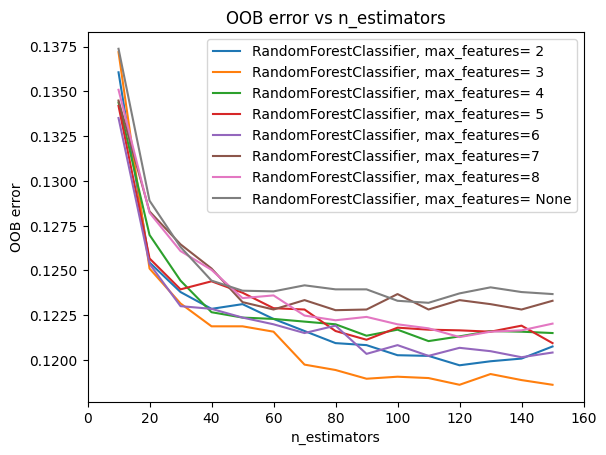

In [ ]:
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators - 10, max_estimators +10)
plt.title('OOB error vs n_estimators')
plt.xlabel("n_estimators")
plt.ylabel("OOB error")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Tìm label với error rate thấp nhất cùng với n_estimators
lowest_error_label = None
lowest_error_rate = float('inf')  # Khởi tạo giá trị error rate thấp nhất là vô cùng
lowest_n_estimators = None  # Biến để lưu giá trị n_estimators tương ứng với error rate thấp nhất

for label, errors in error_rate.items():
    # Tìm error rate thấp nhất trong mỗi label cùng với n_estimators
    min_error = min(errors, key=lambda x: x[1])  # Lấy tuple (n_estimators, error rate) có error rate nhỏ nhất
    min_n_estimators, min_error_rate = min_error  # Lấy giá trị n_estimators và error rate nhỏ nhất

    if min_error_rate < lowest_error_rate:
        lowest_error_rate = min_error_rate
        lowest_error_label = label
        lowest_n_estimators = min_n_estimators  # Cập nhật n_estimators tương ứng

# In ra kết quả label, n_estimators và error rate thấp nhất
print(f"Label with the lowest error rate: {lowest_error_label}")
print(f"Lowest error rate: {lowest_error_rate:.4f} at n_estimators = {lowest_n_estimators}")

Label with the lowest error rate: RandomForestClassifier, max_features= 3
Lowest error rate: 0.1186 at n_estimators = 120


In [ ]:
## Xây dựng mô hình RandomForestClassifier
##------------------------------------------------------------------------------
clf_f   = RandomForestClassifier(n_estimators = 120, max_features = 3, criterion = 'gini', max_depth = 17, oob_score=True, random_state=42)
model   = clf_f.fit(X_train, y_train)

In [ ]:
y_pred= model.predict(X_test)

In [ ]:
def classification_eval(y_test, y_pred):
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

In [ ]:
## Đánh giá mô hình random  bằng các chỉ số
scores = classification_eval(y_test, y_pred)

## Hiển thị giá trị cá chỉ số
print(f'accuray   = {(scores[0] * 100):.1f}%')
print(f'precision = {(scores[1] * 100):.1f}%')
print(f'recall    = {(scores[2] * 100):.1f}%')
print(f'f1        = {(scores[3] * 100):.1f}%')

accuray   = 87.8%
precision = 82.6%
recall    = 77.8%
f1        = 80.1%


[[4221  343]
 [ 467 1632]]


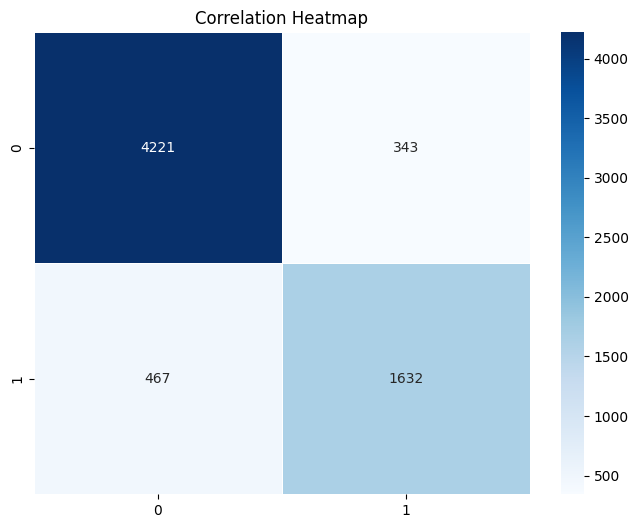

In [ ]:
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(8, 6))
sbn.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt=".0f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()